In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import imageio
import timit_utils as tu
import timit_utils.audio_utils as au
import timit_utils.drawing_utils as du
import librosa
from python_speech_features import mfcc
from python_speech_features import logfbank
from sklearn.metrics import pairwise as pw
from sklearn import preprocessing
import random
import pandas as pd
from matplotlib import pyplot as plt

corpus = tu.Corpus('TIMIT')
train = corpus.train
test = corpus.test
corpus.train, corpus.test

(<timit_utils.core.SubCorpus at 0x10c731550>,
 <timit_utils.core.SubCorpus at 0x1c2920bdd8>)

### Mel-scale Based Features for Speaker ID

In [3]:
data_set = []
label_id = []
label_gen = []
label_dem = []
num_regions = 3 # Number of regions to sample from
# Train and test speakers come from the same 8 regions
all_speaker_regions = list(train.regions.keys())
speaker_regions = [all_speaker_regions[i] for i in np.random.choice(len(all_speaker_regions), replace=False, size=num_regions)]

for p in range(len(train.people)):
    count = 0
    # Only draw speakers from certain regions
    if train.person_by_index(p).region_name in speaker_regions:
        for s in range(len(train.person_by_index(p).sentences)):
            sentence = train.person_by_index(p).sentence_by_index(s).raw_audio
            data_set.append(sentence)
            label_id.append(train.person_by_index(p).name)
            label_gen.append(train.person_by_index(p).gender)
            label_dem.append(train.person_by_index(p).region_name)
for p in range(len(test.people)):
    count = 0
    if test.person_by_index(p).region_name in speaker_regions:
        for s in range(len(test.person_by_index(p).sentences)):
            sentence = test.person_by_index(p).sentence_by_index(s).raw_audio
            data_set.append(sentence)
            label_id.append(test.person_by_index(p).name)
            label_gen.append(test.person_by_index(p).gender)
            label_dem.append(test.person_by_index(p).region_name)
speakers_in_dataset = len(set(label_id))
print('Number of speakers in data: ', speakers_in_dataset)

Number of speakers in data:  233


In [4]:
le1 = preprocessing.LabelEncoder()
le1.fit(label_id)
label_id = le1.transform(label_id)
le2 = preprocessing.LabelEncoder()
le2.fit(label_gen)
label_gen = le2.transform(label_gen)
le3 = preprocessing.LabelEncoder()
le3.fit(label_dem)
label_dem = le3.transform(label_dem)

num_speakers = 20 # number of speakers being considered

sub_data_set = []
sub_label_id = []
sub_label_gen = []
sub_label_dem = []
speak_ind = []
for ind1 in range(num_speakers):
    ind2 = np.random.randint(speakers_in_dataset, size=1)
    while ind2[0] in speak_ind: # Don't repeat speakers
        ind2 = np.random.randint(speakers_in_dataset, size=1)
    speak_ind.append(ind2[0])
act_ind = []
for ID in speak_ind:
    act_ind= np.where(label_id == ID)
    sub_data_set = sub_data_set+data_set[act_ind[0][0]:act_ind[0][-1]+1]
    sub_label_id = sub_label_id+label_id[act_ind[0]].tolist()
    sub_label_gen = sub_label_gen+label_gen[act_ind[0]].tolist()
    sub_label_dem = sub_label_dem+label_dem[act_ind[0]].tolist()

In [5]:
sentence_lengths = []
for p in range(len(train.people)):
    for s in range(len(train.person_by_index(p).sentences)):
        sentence_lengths.append(len(train.person_by_index(p).sentence_by_index(s).raw_audio))
for p in range(len(test.people)):
    for s in range(len(test.person_by_index(p).sentences)):
        sentence_lengths.append(len(test.person_by_index(p).sentence_by_index(s).raw_audio))

In [6]:
def get_filterbank(data,fs,wlen,nfilt):
    # 64-dimensional filterbank coefficients
    logfbank_es = logfbank(data,samplerate=fs,winlen=wlen,nfilt=64)
    # ZMUV the filterbank coefficients
    logfbank_es = (logfbank_es-np.mean(logfbank_es))/np.std(logfbank_es)
    return logfbank_es

In [7]:
fs = 16000
wlen = 0.025
num_train_per_test = 3 # for every 3 training sentences, there is 1 testing sentence
training_set = []
training_label_id = []
training_label_gen = []
training_label_dem = []
testing_set = []
testing_label_id = []
testing_label_gen = []
testing_label_dem = []
for ID in set(sub_label_id):
    person_ind = [i for i, x in enumerate(sub_label_id) if x == ID]
    for i, sent_per_ID in enumerate(person_ind):
        if i%(num_train_per_test+1) == 0: # Add 25% of data to testing set
            testing_set.append(sub_data_set[sent_per_ID])
            testing_label_id.append(sub_label_id[sent_per_ID])
            testing_label_gen.append(sub_label_gen[sent_per_ID])
            testing_label_dem.append(sub_label_dem[sent_per_ID])
        else: # Add 75% of data to training set
            training_set.append(sub_data_set[sent_per_ID])
            training_label_id.append(sub_label_id[sent_per_ID])
            training_label_gen.append(sub_label_gen[sent_per_ID])
            training_label_dem.append(sub_label_dem[sent_per_ID])

# Extract features from 
len_samps = 1 # length of samples in seconds
fs = 16000
ave_seconds_per_ID = sum(sentence_lengths)/(fs*len(sentence_lengths))*10
num_samps_per_ID = round(ave_seconds_per_ID)*4
num_samps_per_ID_test = round(num_samps_per_ID*(1/(num_train_per_test+1)))
num_samps_per_ID_train = num_samps_per_ID-num_samps_per_ID_test
training_data = []
training_l_id = []
training_l_gen = []
training_l_dem = []
testing_data = []
testing_l_id = []
testing_l_gen = []
testing_l_dem = []
for ID_i, ID in enumerate(set(sub_label_id)):
    train_person_ind = [i for i, x in enumerate(training_label_id) if x == ID]
    test_person_ind = [i for i, x in enumerate(testing_label_id) if x == ID]
    for samp in range(num_samps_per_ID_train):
        sent = random.choice(train_person_ind)
        while len(training_set[sent]) < round(fs*len_samps):
            sent = random.choice(train_person_ind)
        start_i = random.randint(0,len(training_set[sent])-round(fs*len_samps))
        curr_data = training_set[sent][start_i:start_i+round(fs*len_samps)]
        training_data.append(get_filterbank(curr_data,fs,wlen,64))
        training_l_id.append(ID_i)
        training_l_gen.append(training_label_gen[sent])
        training_l_dem.append(training_label_dem[sent])
    for samp in range(num_samps_per_ID_test):
        sent = random.choice(test_person_ind)
        while len(testing_set[sent]) < round(fs*len_samps):
            sent = random.choice(test_person_ind)
        start_i = random.randint(0,len(testing_set[sent])-round(fs*len_samps))
        curr_data = testing_set[sent][start_i:start_i+round(fs*len_samps)]
        testing_data.append(get_filterbank(curr_data,fs,wlen,64))
        testing_l_id.append(ID_i)
        testing_l_gen.append(testing_label_gen[sent])
        testing_l_dem.append(testing_label_dem[sent])

In [87]:
class ResBlock(nn.Module):
    def __init__(self,hidden_channels):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=hidden_channels,out_channels=hidden_channels,kernel_size=3,stride=1,padding=1,bias=True)
        self.bn1 = nn.BatchNorm2d(hidden_channels)
        self.conv2 = nn.Conv2d(in_channels=hidden_channels,out_channels=hidden_channels, kernel_size=3, stride=1,padding=1,bias=True)
        self.bn2 = nn.BatchNorm2d(hidden_channels)

    def forward(self, x):
        y = self.conv1(x)
        ##y = F.batch_norm(y,self.running_mu1,self.running_std1)
        y = self.bn1(y)
        y = F.leaky_relu(y,0.1)
        y = self.conv2(y)
        y = self.bn2(y)
        y = F.leaky_relu(y+x,0.1)
        return y

class ResNet(nn.Module):
    def __init__(self,in_channels,hidden_channels,num_speakers,num_regions):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=hidden_channels,kernel_size=5,stride=2,padding=0,bias=True)
        self.resblock = ResBlock(hidden_channels)
        self.fc = nn.Linear(in_features=hidden_channels*24*15,out_features=num_speakers)
        self.fc2 = nn.Linear(in_features=hidden_channels*24*15,out_features=2)
        self.fc3 = nn.Linear(in_features=hidden_channels*24*15,out_features=num_regions)

    def forward(self, x):
        x = F.relu(self.conv1(x),0.1)
        x = F.max_pool2d(x,2)
        x = self.resblock(x)
        x = x.view(x.size(0),-1)
        # Separate fully connected layers
        y1 = self.fc(x)
        y2 = self.fc2(x)
        y3 = self.fc3(x)
        return y1, y2, y3

In [88]:
train_list = []
for ind, data in enumerate(training_data):
    train_list.append((data, training_l_id[ind], training_l_gen[ind], training_l_dem[ind]))
test_list = []
for ind, data in enumerate(testing_data):
    test_list.append((data, testing_l_id[ind], testing_l_gen[ind], testing_l_dem[ind]))

In [ ]:
#batch_sizes = [5,25,50,100]
test_accs = []
num_epochs = 10
test_loader = torch.utils.data.DataLoader(test_list, batch_size=len(test_list), shuffle=True, num_workers=0)
#for batch_size in batch_sizes:
    #batch_test_acc = []
batch_size = 50
# 5 runs
for i in range(5):
    train_loader = torch.utils.data.DataLoader(train_list, batch_size=batch_size, shuffle=True, num_workers=0)
    model = ResNet(1,64,num_speakers,num_regions)
    crit = nn.CrossEntropyLoss()
    crit2 = nn.CrossEntropyLoss()
    crit3 = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    # Train
    epoch_losses = []
    for i in range(num_epochs):
        model.train(True)
        epoch_loss = 0
        for batch_id, (data,speakers,genders,regions) in enumerate(train_loader):
            data = data.unsqueeze(1).float()
            optimizer.zero_grad()
            #Multi-task learning: simultaneously train on speaker identity, gender, and region labels
            y1, y2, y3 = model(data)
            #y2_pred = torch.argmax(y2,axis=1).float()
            loss = 0.8*crit(y1,speakers) + 0.1*crit2(y2,genders) + 0.1*crit3(y3,regions)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        epoch_losses.append(epoch_loss/(len(train_list)+1))
        print('Batch size: {}. Epoch {}: Loss: {:.6f}'.format(batch_size, i+1, epoch_losses[-1]))

    with torch.no_grad():
        model.train(False)
        # Test on entire testing set
        for _, (data,speakers,genders,regions) in enumerate(test_loader):
            data = data.unsqueeze(1).float()
            y_hat, y2, y3 = model(data)
            y_pred = torch.argmax(y_hat,axis=1)
            corr_preds = torch.zeros(len(speakers),1)
            corr_preds[y_pred == speakers] = 1
            curr_test_acc = corr_preds.sum()/len(speakers)*100
            print('Testing accuracy: {:.2f}%'.format(curr_test_acc))
    test_accs.append(curr_test_acc.item())
    #test_accs.append(batch_test_acc)

Batch size: 50. Epoch 1: Loss: 0.105452
Batch size: 50. Epoch 2: Loss: 0.052094
Batch size: 50. Epoch 3: Loss: 0.025415
Batch size: 50. Epoch 4: Loss: 0.007734
Batch size: 50. Epoch 5: Loss: 0.004706
Batch size: 50. Epoch 6: Loss: 0.003488
Batch size: 50. Epoch 7: Loss: 0.002856
Batch size: 50. Epoch 8: Loss: 0.002360
Batch size: 50. Epoch 9: Loss: 0.002075
Batch size: 50. Epoch 10: Loss: 0.001818
Testing accuracy: 80.16%
Batch size: 50. Epoch 1: Loss: 0.092532
Batch size: 50. Epoch 2: Loss: 0.042852
Batch size: 50. Epoch 3: Loss: 0.021655


In [ ]:
# Compare predictions to true labels
df = pd.DataFrame(data={'Predictions': y_pred, 'True labels': speakers})
print(df)

Text(0.5, 1.0, 'Effect of batch size on testing accuracy at 10 epochs')

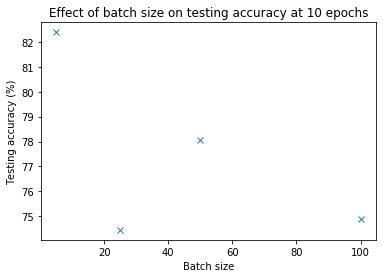

In [80]:
plt.plot(batch_size,np.mean(test_accs,axis=1),'x')
plt.xlabel('Batch size')
plt.ylabel('Testing accuracy (%)')
plt.title('Effect of batch size on testing accuracy at 10 epochs')